# ProsusAI Fine-tuning

In [4]:
# !pip install evaluate
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn import metrics
from datasets import Dataset
from transformers import AutoTokenizer, get_scheduler, AutoModelForSequenceClassification
from tqdm.auto import tqdm

plt.style.use('ggplot')

DATA_PATH = "/kaggle/input/futures-price-prediction/"
RANDOM_STATE = 42

## Preprocessing

In [21]:
df = pd.read_csv("/kaggle/input/futures-price-prediction/processed.csv")
df.head()

,text,is_quote_status,has_card,1_day_after,is_in_reply_to,is_urls,is_thumbnail_title,is_hashtags,year,month,day_of_week
0,metatckr zuckerberg has said that they would b...,0,0,0,0,0,0,0,2024,10,5
1,"you can follow all market news, including for ...",0,0,1,1,1,0,0,2024,9,5
2,just in: apple aapltckr is now reportedly no l...,0,0,1,0,0,0,0,2024,9,5
3,"apple, aapltckr, is no longer a ‘growth engine...",0,0,1,0,0,0,0,2024,9,3
4,here are the hottest and most active bullish a...,0,0,1,0,1,0,0,2024,9,0


In [22]:
df = df[["text", "1_day_after"]].rename({"1_day_after": "label"}, axis=1)

X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
Xtrain, Xval = train_test_split(X_train, test_size=0.2, random_state=RANDOM_STATE)

train = Dataset.from_pandas(Xtrain)
val = Dataset.from_pandas(Xval)
test = Dataset.from_pandas(X_test)

train = train.remove_columns(["__index_level_0__"])
val = val.remove_columns(["__index_level_0__"])
test = test.remove_columns(["__index_level_0__"])

In [23]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_train = train.map(tokenize_function, batched=True)
tokenized_val = val.map(tokenize_function, batched=True)
tokenized_test = test.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_train.set_format("torch")

tokenized_val = tokenized_val.remove_columns(["text"])
tokenized_val = tokenized_val.rename_column("label", "labels")
tokenized_val.set_format("torch")

tokenized_test = tokenized_test.remove_columns(["text"])
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch")

train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_val, batch_size=16)
test_dataloader = DataLoader(tokenized_test, batch_size=16)

Map:   0%|          | 0/5374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

## Train

In [12]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=2, ignore_mismatched_sizes=True)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"device: {device}")
model.to(device)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=5e-5, fused=True)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

metric = evaluate.load("roc_auc")

best_score = 0
for epoch in range(num_epochs):
    model.train()
    progress_bar_train = tqdm(train_dataloader, desc=f"Train Epoch {epoch}")
    for batch in progress_bar_train:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    model.eval()
    all_probs = []
    all_labels = []
    progress_bar_val = tqdm(eval_dataloader, desc=f"Validate Epoch {epoch}")
    for batch in progress_bar_val:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        
        logits = outputs.logits
        probs = softmax(logits, dim=1)[:, 1].detach().cpu()
        labels = batch["labels"].detach().cpu()

        all_probs.extend(probs.numpy())
        all_labels.extend(labels.numpy())

    score = metric.compute(prediction_scores=all_probs, references=all_labels)
    print(f"Epoch {epoch}: ROC-AUC = {score['roc_auc']:.4f}")
    
    if score['roc_auc'] > best_score:
        best_score = score['roc_auc']
        torch.save(model.state_dict(), 'model_weights.pth')

device: cuda


Train Epoch 0:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 0:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 0: ROC-AUC = 0.5299


Train Epoch 1:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1: ROC-AUC = 0.4979


Train Epoch 2:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2: ROC-AUC = 0.5081


Train Epoch 3:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3: ROC-AUC = 0.5265


Train Epoch 4:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4: ROC-AUC = 0.4766


Train Epoch 5:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 5:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5: ROC-AUC = 0.5298


Train Epoch 6:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 6: ROC-AUC = 0.4944


Train Epoch 7:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 7: ROC-AUC = 0.5314


Train Epoch 8:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 8: ROC-AUC = 0.5332


Train Epoch 9:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 9: ROC-AUC = 0.5514


Train Epoch 10:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 10:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 10: ROC-AUC = 0.5632


Train Epoch 11:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 11: ROC-AUC = 0.5611


Train Epoch 12:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 12: ROC-AUC = 0.5726


Train Epoch 13:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 13: ROC-AUC = 0.5682


Train Epoch 14:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 14: ROC-AUC = 0.5624


Train Epoch 15:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 15:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 15: ROC-AUC = 0.5600


Train Epoch 16:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 16: ROC-AUC = 0.5619


Train Epoch 17:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 17: ROC-AUC = 0.5665


Train Epoch 18:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 18: ROC-AUC = 0.5671


Train Epoch 19:   0%|          | 0/336 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 19: ROC-AUC = 0.5652


## Predict

In [33]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=2, ignore_mismatched_sizes=True)
model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", weights_only=True))
model.to(device)
model.eval()

metric = evaluate.load("roc_auc")
all_probs = []
all_labels = []

with torch.no_grad():
    progress_bar_test = tqdm(test_dataloader, desc="Predict test data")
    for batch in progress_bar_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        logits = outputs.logits
        probs = softmax(logits, dim=1)[:, 1].cpu()
        labels = batch["labels"].cpu()
    
        all_probs.extend(probs.numpy())
        all_labels.extend(labels.numpy())

score = metric.compute(prediction_scores=all_probs, references=all_labels)
print(f"Test ROC-AUC = {score['roc_auc']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predict test data:   0%|          | 0/105 [00:00<?, ?it/s]

Test ROC-AUC = 0.5689


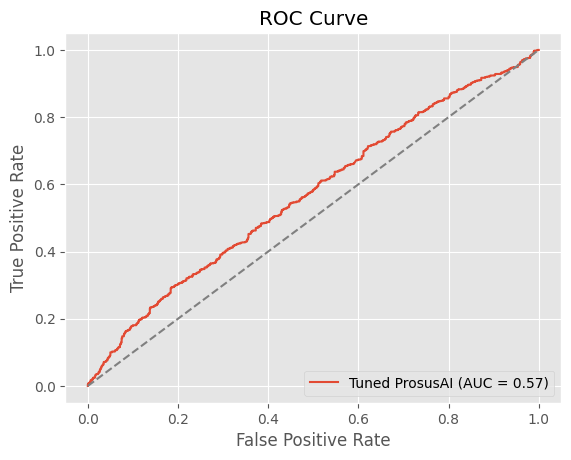

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_probs)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Tuned ProsusAI')
display.plot()
plt.plot([0, 1], [0, 1], r"--", color="grey")
plt.title("ROC Curve")
plt.show()